# Peer-graded Assignment: Segmenting and Clustering Neighborhoods in Toronto

## Notebook part 3: Explore and cluster the neighborhoods in Toronto

In this notebook we will expore and cluster neighborhoods in Toronto

From the dataframe containing the neighborhoods of Toronto we select the Boroughs containing the name "Toronto"  
Next step will be exploring the neighborhoods using geographical data and the Foursquare API

For more information about foursquareand their API please visit:  
https://foursquare.com/

Using  the Foursquare API we will search for the 100 most popular venues in each neighborhood and cluster those neighborhouds based on the foursquare data.

    

### First we have to import the following Libraries 

In [1]:
import pandas as pd # the pandas package
import numpy as np # the numpy package
#!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
#!pip install folium
import requests # retrieve function used to get the nearby venues
import folium # map rendering library
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
# import k-means from clustering stage
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

### Loading the table prepaired in the previouse notebook from the Excel data file.

In [2]:
# loading dataframe from excel file into dataframe
df = pd.read_excel('./Data/df_coordinates.xlsx')
df.head()

Postal Code           Borough                                 Neighborhood  \
0         M3A        North York                                    Parkwoods   
1         M4A        North York                             Victoria Village   
2         M5A  Downtown Toronto                    Regent Park, Harbourfront   
3         M6A        North York             Lawrence Manor, Lawrence Heights   
4         M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government   

   Latitude  Longitude  
0  43.75245  -79.32991  
1  43.73057  -79.31306  
2  43.65512  -79.36264  
3  43.72327  -79.45042  
4  43.66253  -79.39188

### Selecting all Boroughs containing the name Toronto

To limit the amount of neighborhoods to be analysed we slice the dataset. Only neighborhoods withing Boroughs containing the word 'Toronto' will be selected.

In [3]:
df_toronto = df.loc[df['Borough'].str.contains(pat = 'Toronto')].reset_index(drop=True)
#df_toronto.head


### First we have to find the coordinates for the City of Toronto

 

In [4]:
address = 'Toronto, CA'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


### Now we have the coordinates of Toronto lets put up a map to visualise its location

We make use of the package folium, which is a great package for creating these types of maps.  
After creating the map object we use the dataframe containing the neighborhood coordinates to mark them into the map.

In [7]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)


# add markers to map
for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Borough'], df_toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

## To explore the neighbourhoods within toronto we will use the foursquare data

To be able to make use of Foursquare you have to create an account which you can do for free.  
After registering you will receive credentials to user for the API calls. 

In [38]:
# creating initial variables needed for usage of the API
CLIENT_ID = '***************************' # your Foursquare ID
CLIENT_SECRET = '***********************' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

#print('Your credentails:')
#print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' + CLIENT_SECRET)

### Exploring the neighborhoods

We want to explore what kind of venues exist in each neighborhood.  
Therefore we create a function which automize the process of request to the Foursquare database using the API for every geographical location in the dataframe 'df_toronto'

In [9]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Retrieving the venues using the funtion 'getNearbyVenues'

In [10]:
# retrieving all the venues in a radius of 500 meter fro the center locations of the neighborhoods
toronto_venues = getNearbyVenues(names=df_toronto['Neighborhood'],
                                   latitudes=df_toronto['Latitude'],
                                   longitudes=df_toronto['Longitude']
                                  )

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West, Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
R

In [11]:
print(toronto_venues.shape)
toronto_venues.head()

(1706, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Regent Park, Harbourfront               43.65512               -79.36264   
1  Regent Park, Harbourfront               43.65512               -79.36264   
2  Regent Park, Harbourfront               43.65512               -79.36264   
3  Regent Park, Harbourfront               43.65512               -79.36264   
4  Regent Park, Harbourfront               43.65512               -79.36264   

                    Venue  Venue Latitude  Venue Longitude  Venue Category  
0        Roselle Desserts       43.653447       -79.362017          Bakery  
1           Tandem Coffee       43.653559       -79.361809     Coffee Shop  
2  Figs Breakfast & Lunch       43.655675       -79.364503  Breakfast Spot  
3         The Yoga Lounge       43.655515       -79.364955     Yoga Studio  
4     Body Blitz Spa East       43.654735       -79.359874             Spa

Let's check how many venues were returned for each neighborhood


In [12]:
toronto_venues.groupby('Neighborhood').count()

Neighborhood Latitude  \
Neighborhood                                                                
Berczy Park                                                            61   
Brockton, Parkdale Village, Exhibition Place                           84   
Business reply mail Processing Centre, South Ce...                    100   
CN Tower, King and Spadina, Railway Lands, Harb...                     78   
Central Bay Street                                                     61   
Christie                                                               11   
Church and Wellesley                                                   81   
Commerce Court, Victoria Hotel                                        100   
Davisville                                                             26   
Davisville North                                                        8   
Dufferin, Dovercourt Village                                           16   
First Canadian Place, Underground city                                100   
Forest Hill North & West, Forest Hill Road Park                         2   
Garden District, Ryerson                                              100   
Harbourfront East, Union Station, Toronto Islands                      54   
High Park, The Junction South                                           1   
India Bazaar, The Beaches West                                         20   
Kensington Market, Chinatown, Grange Park                              47   
Lawrence Park                                                           2   
Little Portugal, Trinity                                               42   
Moore Park, Summerhill East                                             5   
North Toronto West, Lawrence Park                                       3   
Parkdale, Roncesvalles                                                 52   
Queen's Park, Ontario Provincial Government                            18   
Regent Park, Harbourfront                                              23   
Richmond, Adelaide, King                                              100   
Rosedale                                                                4   
Roselawn                                                                2   
Runnymede, Swansea                                                     38   
St. James Town                                                         79   
St. James Town, Cabbagetown                                            45   
Stn A PO Boxes                                                        100   
Studio District                                                        52   
Summerhill West, Rathnelly, South Hill, Forest ...                      6   
The Annex, North Midtown, Yorkville                                    22   
The Beaches                                                             5   
The Danforth West, Riverdale                                            7   
Toronto Dominion Centre, Design Exchange                              100   
University of Toronto, Harbord                                         51   

                                                    Neighborhood Longitude  \
Neighborhood                                                                 
Berczy Park                                                             61   
Brockton, Parkdale Village, Exhibition Place                            84   
Business reply mail Processing Centre, South Ce...                     100   
CN Tower, King and Spadina, Railway Lands, Harb...                      78   
Central Bay Street                                                      61   
Christie                                                                11   
Church and Wellesley                                                    81   
Commerce Court, Victoria Hotel                                         100   
Davisville                                                              26   
Davisville North                    

#### Let's find out how many unique categories can be curated from all the returned venues


In [13]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 223 uniques categories.


## 3. Analyze Each Neighborhood


In [14]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]


And let's examine the new dataframe size.


In [15]:
toronto_onehot.shape

(1706, 223)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category


In [16]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head(5)

Neighborhood  Yoga Studio  \
0                                        Berczy Park     0.016393   
1       Brockton, Parkdale Village, Exhibition Place     0.011905   
2  Business reply mail Processing Centre, South C...     0.000000   
3  CN Tower, King and Spadina, Railway Lands, Har...     0.012821   
4                                 Central Bay Street     0.000000   

   Accessories Store  Adult Boutique  American Restaurant  Antique Shop  \
0           0.000000             0.0                 0.00      0.016393   
1           0.011905             0.0                 0.00      0.000000   
2           0.000000             0.0                 0.02      0.000000   
3           0.000000             0.0                 0.00      0.000000   
4           0.000000             0.0                 0.00      0.000000   

   Aquarium  Art Gallery  Art Museum  Arts & Crafts Store  ...  \
0       0.0     0.016393    0.000000              0.00000  ...   
1       0.0     0.000000    0.000000              0.02381  ...   
2       0.0     0.010000    0.000000              0.00000  ...   
3       0.0     0.000000    0.000000              0.00000  ...   
4       0.0     0.016393    0.016393              0.00000  ...   

   Toy / Game Store  Trail  Train Station  Vegetarian / Vegan Restaurant  \
0               0.0    0.0       0.000000                       0.016393   
1               0.0    0.0       0.000000                       0.011905   
2               0.0    0.0       0.000000                       0.020000   
3               0.0    0.0       0.012821                       0.000000   
4               0.0    0.0       0.000000                       0.000000   

   Veterinarian  Video Game Store  Vietnamese Restaurant  Wine Bar  Wine Shop  \
0      0.000000          0.000000               0.000000  0.000000        0.0   
1      0.000000          0.000000               0.000000  0.000000        0.0   
2      0.000000          0.000000               0.000000  0.010000        0.0   
3      0.012821          0.000000               0.000000  0.000000        0.0   
4      0.000000          0.016393               0.016393  0.016393        0.0   

   Wings Joint  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          0.0  

[5 rows x 223 columns]

#### Let's confirm the new size


In [17]:
toronto_grouped.shape

(39, 223)

#### Let's print each neighborhood along with the top 5 most common venues


In [18]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
                venue  freq
0         Coffee Shop  0.08
1        Cocktail Bar  0.05
2  Seafood Restaurant  0.05
3            Beer Bar  0.03
4         Cheese Shop  0.03


----Brockton, Parkdale Village, Exhibition Place----
            venue  freq
0     Coffee Shop  0.06
1            Café  0.06
2             Bar  0.06
3      Restaurant  0.05
4  Sandwich Place  0.04


----Business reply mail Processing Centre, South Central Letter Processing Plant Toronto----
              venue  freq
0       Coffee Shop  0.07
1             Hotel  0.05
2              Café  0.05
3  Asian Restaurant  0.03
4  Sushi Restaurant  0.03


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
                venue  freq
0         Coffee Shop  0.06
1  Italian Restaurant  0.06
2                Café  0.05
3                Park  0.04
4                 Bar  0.04


----Central Bay Street----
                       venue  freq
0            

#### Let's put that into a _pandas_ dataframe


First, let's write a function to sort the venues in descending order.


In [19]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.


In [20]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue  \
0                                        Berczy Park           Coffee Shop   
1       Brockton, Parkdale Village, Exhibition Place                  Café   
2  Business reply mail Processing Centre, South C...           Coffee Shop   
3  CN Tower, King and Spadina, Railway Lands, Har...           Coffee Shop   
4                                 Central Bay Street           Coffee Shop   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0    Seafood Restaurant          Cocktail Bar              Beer Bar   
1           Coffee Shop                   Bar            Restaurant   
2                  Café                 Hotel                   Gym   
3    Italian Restaurant                  Café                   Bar   
4        Clothing Store        Sandwich Place       Bubble Tea Shop   

  5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0        Farmers Market                Bakery           Cheese Shop   
1        Sandwich Place             Gift Shop    Italian Restaurant   
2      Sushi Restaurant      Asian Restaurant            Steakhouse   
3     French Restaurant                  Park            Restaurant   
4                  Café           Pizza Place                 Plaza   

  8th Most Common Venue      9th Most Common Venue 10th Most Common Venue  
0        Breakfast Spot                 Restaurant         Clothing Store  
1        Breakfast Spot                  Nightclub            Supermarket  
2       Thai Restaurant                        Bar     Seafood Restaurant  
3                   Spa                  Speakeasy                 Bakery  
4        Cosmetics Shop  Middle Eastern Restaurant     Mexican Restaurant

## 4. Cluster Neighborhoods


Run _k_-means to cluster the neighborhood into 5 clusters.


When using k-means clustering on of the important questions to aske: what shoul dbe the value for k.
Using multiple runs fr different values of k. we use the 'elbow method' to determin optimal value of k.

We can use the method Inertia which gives the sum of squared distances of the datapoints to their closest cluster center

In [22]:
toronto_grouped_clustering = toronto_grouped.drop(['Neighborhood'], axis=1)

distortions = []
inertias = []
mapping1 = []
mapping2 = []
sil_test = []
labels = []
k_value = range(2,10)
for n in k_value:
    TOR_clustered = KMeans(n_clusters=n, random_state=1, n_init = 10).fit(toronto_grouped_clustering)
    #Elbow method
    distortion_value =(sum(np.min(cdist(toronto_grouped_clustering, TOR_clustered.cluster_centers_, 'euclidean'),axis=1))/toronto_grouped_clustering.shape[0])
    distortions.append(distortion_value) 
    inertias.append(TOR_clustered.inertia_) 
  
    #Silhouette test
    labels = TOR_clustered.labels_
    sil_test.append(silhouette_score(toronto_grouped_clustering,labels,metric = 'euclidean'))

        

### After running the k-means clustering for a range of k, we now visualise the performance metrics for elbow method and silhouette score to choose the optimal value of k

- elbow method : wide used as apprach for finding optimal number of k.
- Silhouette method: The Silhouette method measures how similar a datapoint is to its own cluster. The optimal value should be the higest value in the rance +1 and -1

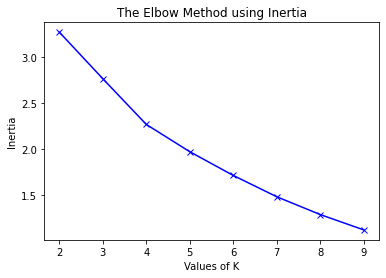

In [37]:
#Elbow score
plt.plot(k_value, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

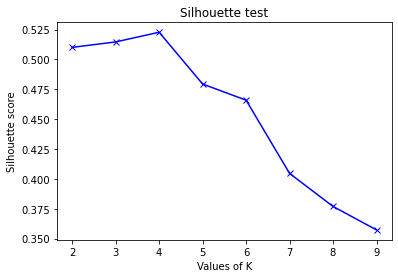

In [24]:
### Silhouette score
plt.plot(k_value, sil_test, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette score')
plt.title('Silhouette test')
plt.show()


Result: As shown above, the elbow graph shows a slight elbow point at k=4 and if we look at the silhouette graph we see that k=4 produces the highest score. Therefor we choose K=4 to perform the final k-means clustering.


In [25]:
# Clustering the data using value k=4

kclusters = 4

kmeans=[]

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=1, n_init = 10).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.


In [26]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df_toronto

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

Postal Code           Borough                                 Neighborhood  \
0         M5A  Downtown Toronto                    Regent Park, Harbourfront   
1         M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government   
2         M5B  Downtown Toronto                     Garden District, Ryerson   
3         M5C  Downtown Toronto                               St. James Town   
4         M4E      East Toronto                                  The Beaches   

   Latitude  Longitude  Cluster Labels 1st Most Common Venue  \
0  43.65512  -79.36264               0           Coffee Shop   
1  43.66253  -79.39188               0           Coffee Shop   
2  43.65739  -79.37804               0           Coffee Shop   
3  43.65215  -79.37587               0           Coffee Shop   
4  43.67709  -79.29547               0     Health Food Store   

  2nd Most Common Venue  3rd Most Common Venue 4th Most Common Venue  \
0        Breakfast Spot            Yoga Studio                Bakery   
1        Sandwich Place  Portuguese Restaurant   Fried Chicken Joint   
2        Clothing Store         Cosmetics Shop                 Hotel   
3                 Hotel         Cosmetics Shop                  Café   
4                 Trail       Asian Restaurant                   Pub   

  5th Most Common Venue      6th Most Common Venue 7th Most Common Venue  \
0             Wine Shop         Italian Restaurant            Food Truck   
1                  Bank              Burrito Place             Gastropub   
2                  Café  Middle Eastern Restaurant   Japanese Restaurant   
3    Italian Restaurant             Clothing Store          Cocktail Bar   
4            Donut Shop          Fish & Chips Shop  Fast Food Restaurant   

    8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0             Event Space     Electronics Store    Distribution Center  
1                 Theater    Italian Restaurant     Falafel Restaurant  
2  Furniture / Home Store      Ramen Restaurant        Bubble Tea Shop  
3               Gastropub   Moroccan Restaurant     Seafood Restaurant  
4          Farmers Market                  Farm     Falafel Restaurant

## Visualise the clustering using Folium

In [30]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.6).add_to(map_clusters)
       
map_clusters

## Finally lets print the individual clusters for further inspection

## Cluster 1

In [32]:
# display cluster 1 
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

Borough  Cluster Labels 1st Most Common Venue  \
0   Downtown Toronto               0           Coffee Shop   
1   Downtown Toronto               0           Coffee Shop   
2   Downtown Toronto               0           Coffee Shop   
3   Downtown Toronto               0           Coffee Shop   
4       East Toronto               0     Health Food Store   
5   Downtown Toronto               0           Coffee Shop   
6   Downtown Toronto               0           Coffee Shop   
7   Downtown Toronto               0                  Café   
8   Downtown Toronto               0           Coffee Shop   
9       West Toronto               0                  Park   
10  Downtown Toronto               0           Coffee Shop   
11      West Toronto               0                   Bar   
12      East Toronto               0        Ice Cream Shop   
13  Downtown Toronto               0           Coffee Shop   
14      West Toronto               0                  Café   
15      East Toronto               0           Pizza Place   
16  Downtown Toronto               0           Coffee Shop   
17      East Toronto               0    Italian Restaurant   
20   Central Toronto               0        Breakfast Spot   
24   Central Toronto               0                  Café   
25      West Toronto               0           Coffee Shop   
26   Central Toronto               0          Dessert Shop   
27  Downtown Toronto               0                  Café   
28      West Toronto               0           Coffee Shop   
29   Central Toronto               0     Convenience Store   
30  Downtown Toronto               0                  Café   
31   Central Toronto               0    Light Rail Station   
32  Downtown Toronto               0           Coffee Shop   
34  Downtown Toronto               0           Coffee Shop   
35  Downtown Toronto               0           Coffee Shop   
36  Downtown Toronto               0           Coffee Shop   
37  Downtown Toronto               0           Coffee Shop   
38      East Toronto               0           Coffee Shop   

            2nd Most Common Venue  3rd Most Common Venue  \
0                  Breakfast Spot            Yoga Studio   
1                  Sandwich Place  Portuguese Restaurant   
2                  Clothing Store         Cosmetics Shop   
3                           Hotel         Cosmetics Shop   
4                           Trail       Asian Restaurant   
5              Seafood Restaurant           Cocktail Bar   
6                  Clothing Store         Sandwich Place   
7                   Grocery Store            Coffee Shop   
8                            Café                  Hotel   
9          Furniture / Home Store               Pharmacy   
10                          Hotel    Japanese Restaurant   
11                   Cocktail Bar             Restaurant   
12                           Park               Bus Line   
13                          Hotel                   Café   
14                    Coffee Shop                    Bar   
15           Fast Food Restaurant     Italian Restaurant   
16                          Hotel             Restaurant   
17                        Brewery                  Diner   
20                           Park                  Hotel   
24                 Sandwich Place           Burger Joint   
25    Eastern European Restaurant       Sushi Restaurant   
26                    Coffee Shop         Sandwich Place   
27                         Bakery            Coffee Shop   
28                           Café                 Bakery   
29                            Gym                   Park   
30  Vegetarian / Vegan Restaurant            Coffee Shop   
31                    Coffee Shop           Liquor Store   
32             Italian Restaurant                   Café   
34                           Café                  Hotel   
35                           Park             Restaurant   
36                          Hotel           

## Cluster 2

In [33]:
# display cluster 2 
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

Borough  Cluster Labels 1st Most Common Venue  \
21   Central Toronto               1                  Park   
22      West Toronto               1                  Park   
23   Central Toronto               1              Gym Pool   
33  Downtown Toronto               1                  Park   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
21      Business Service           Wings Joint           Dry Cleaner   
22           Wings Joint            Donut Shop     Fish & Chips Shop   
23            Playground                  Park           Wings Joint   
33            Playground            Bike Trail           Wings Joint   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
21     Fish & Chips Shop  Fast Food Restaurant        Farmers Market   
22  Fast Food Restaurant        Farmers Market                  Farm   
23            Donut Shop  Fast Food Restaurant        Farmers Market   
33           Dry Cleaner     Fish & Chips Shop  Fast Food Restaurant   

   8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
21                  Farm    Falafel Restaurant            Event Space  
22    Falafel Restaurant           Event Space   Ethiopian Restaurant  
23                  Farm    Falafel Restaurant            Event Space  
33        Farmers Market                  Farm     Falafel Restaurant

## Cluster 3

In [34]:
# display cluster 3 
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

Borough  Cluster Labels    1st Most Common Venue  \
19  Central Toronto               2  Health & Beauty Service   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
19          Home Service            Donut Shop     Fish & Chips Shop   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
19  Fast Food Restaurant        Farmers Market                  Farm   

   8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
19    Falafel Restaurant           Event Space   Ethiopian Restaurant

## Cluster 4

In [47]:
# display cluster 4 
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

Borough  Cluster Labels 1st Most Common Venue  \
4       East Toronto               3                   Pub   
7   Downtown Toronto               3     Korean Restaurant   
9       West Toronto               3                  Café   
11      West Toronto               3                   Bar   
14      West Toronto               3                  Café   
15      East Toronto               3                  Park   
17      East Toronto               3           Coffee Shop   
20   Central Toronto               3           Pizza Place   
21   Central Toronto               3                  Park   
22      West Toronto               3                  Café   
23   Central Toronto               3    Italian Restaurant   
24   Central Toronto               3                  Café   
25      West Toronto               3           Coffee Shop   
26   Central Toronto               3           Pizza Place   
27  Downtown Toronto               3                  Café   
28      West Toronto               3           Coffee Shop   
30  Downtown Toronto               3                  Café   
31   Central Toronto               3           Coffee Shop   
35  Downtown Toronto               3           Coffee Shop   

            2nd Most Common Venue          3rd Most Common Venue  \
4                     Pizza Place                           Café   
7                   Grocery Store                    Coffee Shop   
9                             Bar                         Bakery   
11                           Café  Vegetarian / Vegan Restaurant   
14                    Coffee Shop                     Restaurant   
15                    Coffee Shop           Fast Food Restaurant   
17                    Pizza Place                          Diner   
20                           Park                            Gym   
21                           Café                           Bank   
22              Convenience Store                            Bar   
23                    Coffee Shop                           Café   
24             Italian Restaurant                 Sandwich Place   
25                     Restaurant                           Café   
26                 Sandwich Place                    Coffee Shop   
27                         Bakery                     Restaurant   
28                           Café                    Pizza Place   
30  Vegetarian / Vegan Restaurant                            Bar   
31             Italian Restaurant               Sushi Restaurant   
35                           Café                    Pizza Place   

   4th Most Common Venue 5th Most Common Venue          6th Most Common Venue  \
4         Sandwich Place                   Bar            Japanese Restaurant   
7                   Café                  Park                            Pub   
9            Coffee Shop                  Park                       Pharmacy   
11    Italian Restaurant           Coffee Shop                   Cocktail Bar   
14                   Bar                Bakery         Furniture / Home Store   
15     Indian Restaurant         Grocery Store             Light Rail Station   
17   American Restaurant                   Bar                  Grocery Store   
20           Coffee Shop            Taco Place               Sushi Restaurant   
21              Pharmacy           Coffee Shop       Mediterranean Restaurant   
22       Thai Restaurant           Coffee Shop             Italian Restaurant   
23        Clothing Store   Sporting Goods Shop                   Skating Rink   
24           Coffee Shop        History Museum             Mexican Restaurant   
25         Grocery Store                Bakery    Eastern European Restaurant   
26          Dessert Shop    Italian Restaurant                           Café   
27           Coffee Shop                   Bar  Vegetarian / Vegan Restaurant   
28                   Pub      Sushi Restaurant                         Bakery   
30           Coffee Shop          

# This Concludes the end of the Clustering of Neighborhoods in the City of Toronto